In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from prometheus_pandas import query
pd.__version__

'2.0.0'

In [3]:
p = query.Prometheus('http://192.168.178.64:9090')
step = "1s"

In [49]:
# We're scraping much more data than we actually need.
# This is especially true for devices.
# In this section we define which devices we actually want to analyze.

NET_DEVICES=["docker0","enp7s0","lo"]
DISK_DEVICES=["sda"]

# Baseline Analysis

Here we take a look at the Baseline of our DUT


In [4]:
bm = pd.read_csv('baseline.csv')
bm

,Start,End,Duration,Energy
0,1681634834,1681635134,5m,4


# Utils

In [27]:
def prepare_query_range_as_dataframe(query, start, end, step=step):
    metrics = p.query_range(query, start, end, step)
    metrics = metrics.assign(seconds=range(len(metrics)))
    
    return metrics

def prepare_query_metrics_as_series(query, end):
    return p.query(query, end)

# Power Stats

          Current       Watts     Voltage
count  301.000000  301.000000  301.000000
mean   262.259136   47.438538  237.239203
std      0.786951    0.497034    0.427307
min    261.000000   47.000000  237.000000
25%    262.000000   47.000000  237.000000
50%    262.000000   47.000000  237.000000
75%    263.000000   48.000000  237.000000
max    265.000000   48.000000  238.000000


(0.0, 60.0)

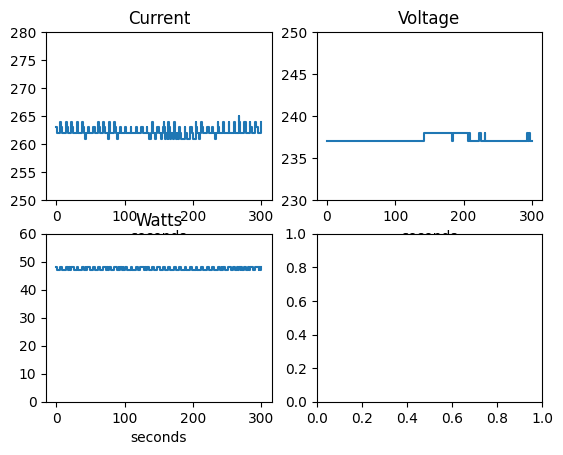

In [67]:
result = [prepare_query_range_as_dataframe('{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}',start, end) for start, end in zip(bm['Start'], bm['End'])]
result = pd.concat(result)
result.columns = ['Current', 'Watts', 'Voltage', 'seconds']

print(result[['Current', 'Watts', 'Voltage']].describe())

grouped_mean = result.groupby(by=['seconds']).mean()

fig, axes = plt.subplots(nrows=2, ncols=2)
grouped_mean['Current'].plot(drawstyle='steps', ax=axes[0,0]);
axes[0,0].set_title('Current')
axes[0,0].set_ylim(bottom=250, top=280)
grouped_mean['Voltage'].plot(drawstyle='steps', ax=axes[0,1]);
axes[0,1].set_title('Voltage')
axes[0,1].set_ylim(bottom=230, top=250)
grouped_mean['Watts'].plot(drawstyle='steps', ax=axes[1,0]);
axes[1,0].set_title('Watts')
axes[1,0].set_ylim(bottom=0, top=60)

## CPU

{mode="idle"}       298.227843
{mode="iowait"}       0.003135
{mode="irq"}          0.000000
{mode="nice"}         0.000000
{mode="softirq"}      0.036998
{mode="steal"}        0.000000
{mode="system"}       0.204431
{mode="user"}         1.242893
dtype: float64


<Axes: ylabel='CPU seconds'>

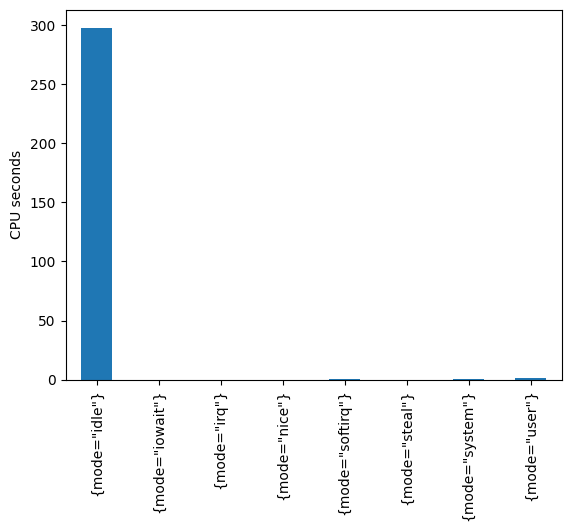

In [28]:
result = [prepare_query_metrics_as_series(f"avg by (mode) (increase(node_cpu_seconds_total[{duration}]))", end) for duration, end in zip(bm['Duration'], bm['End'])]
result = pd.concat(result)

grouped_result = result.groupby(level=0).mean()
print(grouped_result)
grouped_result.plot.bar(ylabel='CPU seconds')

       {mode="idle"}  {mode="iowait"}  {mode="irq"}  {mode="nice"}   
count     301.000000       301.000000         301.0          301.0  \
mean       99.407577         0.001038           0.0            0.0   
std         0.082584         0.002668           0.0            0.0   
min        99.076389         0.000000           0.0            0.0   
25%        99.361111         0.000000           0.0            0.0   
50%        99.402778         0.000000           0.0            0.0   
75%        99.451389         0.000000           0.0            0.0   
max        99.840278         0.013889           0.0            0.0   

       {mode="softirq"}  {mode="steal"}  {mode="system"}  {mode="user"}   
count        301.000000           301.0       301.000000     301.000000  \
mean           0.012159             0.0         0.068568       0.416182   
std            0.010580             0.0         0.014193       0.036469   
min            0.000000             0.0         0.027778       0.3194

<Axes: xlabel='seconds', ylabel='%'>

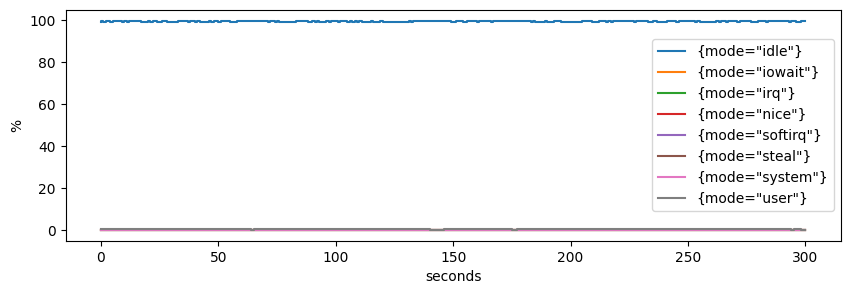

In [7]:
result = [prepare_query_range_as_dataframe('avg by (mode) (rate(node_cpu_seconds_total[10s]) * 100)', start, end) for start, end in zip(bm['Start'], bm['End'])]
result = pd.concat(result)

print(result.describe())

grouped_mean = result.groupby(by=['seconds']).mean()
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylim=(-5,105),ylabel='%')

## Memory

       {instance="192.168.178.79:9100",job="node"}     seconds
count                                   301.000000  301.000000
mean                                      1.063313  150.000000
std                                       0.004534   87.035433
min                                       1.055603    0.000000
25%                                       1.059990   75.000000
50%                                       1.063192  150.000000
75%                                       1.065911  225.000000
max                                       1.077417  300.000000


<Axes: xlabel='seconds', ylabel='%'>

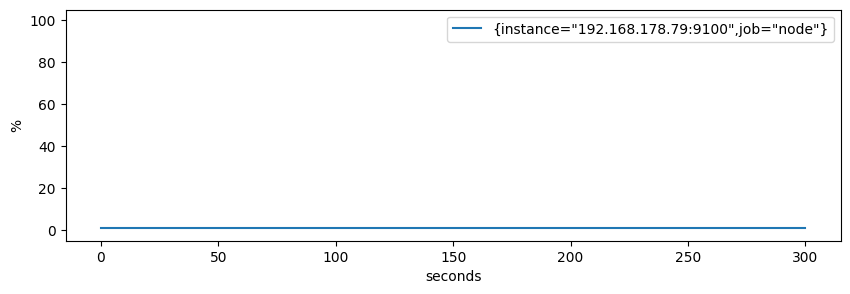

In [8]:
rng = "10s"
query = f"""
    100 * (1 - ((avg_over_time(node_memory_MemFree_bytes[{rng}]) + avg_over_time(node_memory_Cached_bytes[{rng}]) + avg_over_time(node_memory_Buffers_bytes[{rng}])) / avg_over_time(node_memory_MemTotal_bytes[{rng}])))
    """

result = [prepare_query_range_as_dataframe(query, start, end) for start, end in zip(bm['Start'], bm['End'])]
result = pd.concat(result)

print(result.describe())

grouped_mean = result.groupby(by=['seconds']).mean()
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylim=(-5,105),ylabel='%')

## Network

In [56]:
# This is going to be the label filter we're going to use
net_filter_label = f"{{device=~\"{'|'.join(NET_DEVICES)}\"}}"

{device=~"docker0|enp7s0|lo"}


### Received KBytes

{device="docker0"}         0.000000
{device="enp7s0"}     313462.876254
{device="lo"}              0.000000
dtype: float64


<Axes: ylabel='Received KBytes'>

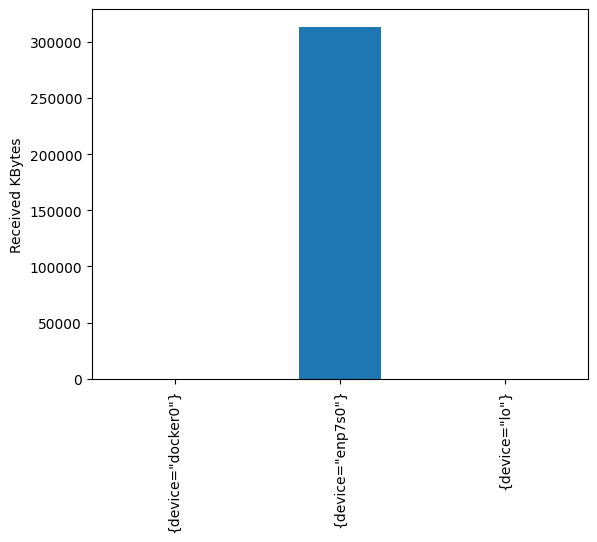

In [57]:
result = [prepare_query_metrics_as_series(f"sum by(device) (increase(node_network_receive_bytes_total{net_filter_label}[{duration}]))", end) for duration, end in zip(bm['Duration'], bm['End'])]
result = pd.concat(result)

grouped_result = result.groupby(level=0).mean()
print(grouped_result)
grouped_result.plot.bar(ylabel='Received KBytes')

       {device="docker0"}  {device="enp7s0"}  {device="lo"}     seconds
count               301.0         301.000000          301.0  301.000000
mean                  0.0        1045.552602            0.0  150.000000
std                   0.0          43.988468            0.0   87.035433
min                   0.0         944.666667            0.0    0.000000
25%                   0.0        1012.444444            0.0   75.000000
50%                   0.0        1042.666667            0.0  150.000000
75%                   0.0        1073.333333            0.0  225.000000
max                   0.0        1157.333333            0.0  300.000000


<Axes: xlabel='seconds', ylabel='Bytes'>

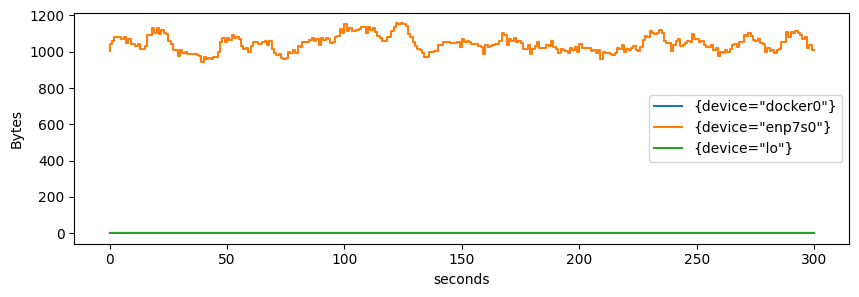

In [59]:
result = [prepare_query_range_as_dataframe(f"avg by (device) (rate(node_network_receive_bytes_total{net_filter_label}[10s]))", start, end) for start, end in zip(bm['Start'], bm['End'])]
result = pd.concat(result)

print(result.describe())

grouped_mean = result.groupby(by=['seconds']).mean()
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='Bytes')

### Sent KByte

{device="docker0"}    0.000000e+00
{device="enp7s0"}     5.944046e+06
{device="lo"}         0.000000e+00
dtype: float64


<Axes: ylabel='Sent KBytes'>

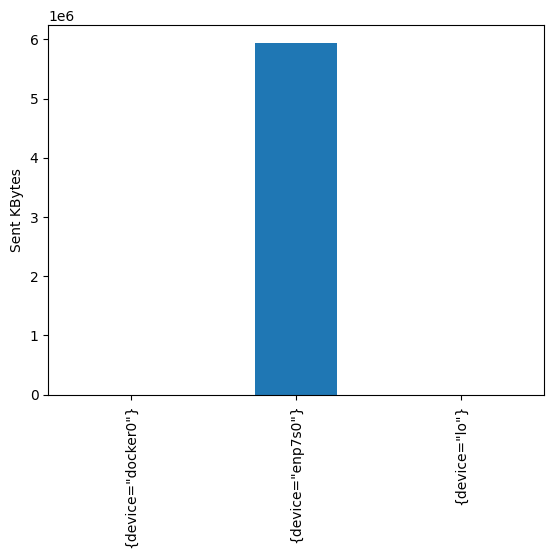

In [60]:
result = [prepare_query_metrics_as_series(f"sum by(device) (increase(node_network_transmit_bytes_total{net_filter_label}[{duration}]))", end) for duration, end in zip(bm['Duration'], bm['End'])]
result = pd.concat(result)

grouped_result = result.groupby(level=0).mean()
print(grouped_result)
grouped_result.plot.bar(ylabel='Sent KBytes')

       {device="docker0"}  {device="enp7s0"}  {device="lo"}     seconds
count               301.0         301.000000          301.0  301.000000
mean                  0.0       19813.594684            0.0  150.000000
std                   0.0           8.070060            0.0   87.035433
min                   0.0       19785.111111            0.0    0.000000
25%                   0.0       19808.444444            0.0   75.000000
50%                   0.0       19814.222222            0.0  150.000000
75%                   0.0       19819.000000            0.0  225.000000
max                   0.0       19835.888889            0.0  300.000000


<Axes: xlabel='seconds', ylabel='Bytes'>

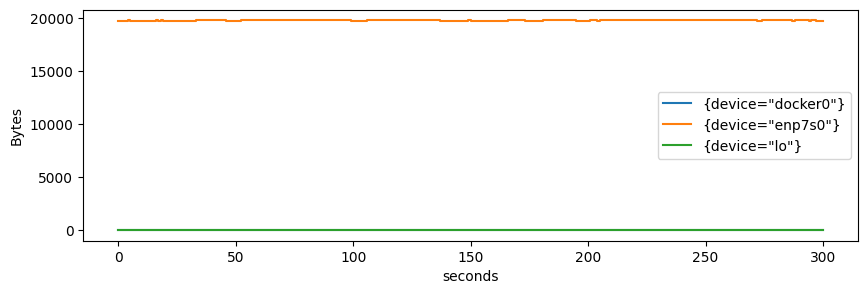

In [61]:
result = [prepare_query_range_as_dataframe(f"avg by (device) (rate(node_network_transmit_bytes_total{net_filter_label}[10s]))", start, end) for start, end in zip(bm['Start'], bm['End'])]
result = pd.concat(result)

print(result.describe())

grouped_mean = result.groupby(by=['seconds']).mean()
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='Bytes')

# Disk

In [62]:
# This is going to be the label filter we're going to use
disk_filter_label = f"{{device=~\"{'|'.join(DISK_DEVICES)}\"}}"

In [63]:
result = [prepare_query_metrics_as_series(f"increase(node_disk_io_time_seconds_total{disk_filter_label}[{duration}])", end) for duration, end in zip(bm['Duration'], bm['End'])]
result = pd.concat(result)

grouped_result = result.groupby(level=0).mean()
print(grouped_result)

{device="sda",instance="192.168.178.79:9100",job="node"}    0.028094
dtype: float64


       {device="sda",instance="192.168.178.79:9100",job="node"}     seconds
count                                         301.000000         301.000000
mean                                            0.000093         150.000000
std                                             0.000269          87.035433
min                                             0.000000           0.000000
25%                                             0.000000          75.000000
50%                                             0.000000         150.000000
75%                                             0.000000         225.000000
max                                             0.001778         300.000000


<Axes: xlabel='seconds', ylabel='I/O seconds'>

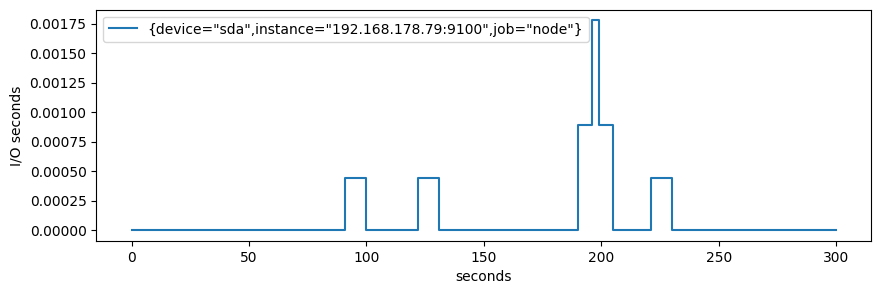

In [64]:
result = [prepare_query_range_as_dataframe(f"rate(node_disk_io_time_seconds_total{disk_filter_label}[10s])", start, end) for start, end in zip(bm['Start'], bm['End'])]
result = pd.concat(result)

print(result.describe())

grouped_mean = result.groupby(by=['seconds']).mean()
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='I/O seconds')

# Interrupts

In [65]:
interrupts_filter = f"{{devices=\"\"}}"

{type="CAL"}     71.0
{type="LOC"}    393.0
{type="RES"}      2.0
dtype: float64


<Axes: ylabel='Interrupts'>

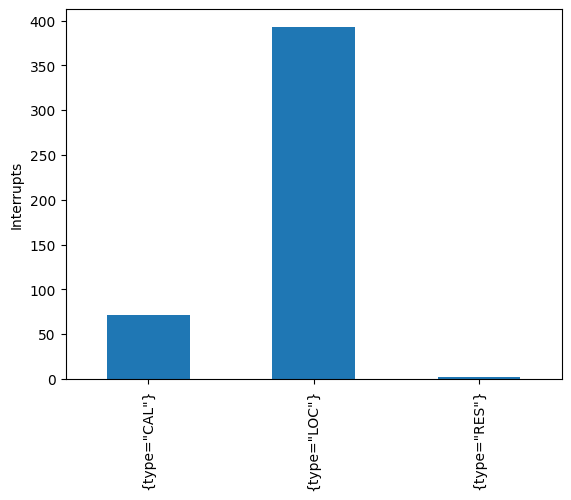

In [66]:
result = [prepare_query_metrics_as_series(f"sum by (devices, type) (idelta(node_interrupts_total{interrupts_filter}[{duration}]) > 0)", end) for duration, end in zip(bm['Duration'], bm['End'])]
result = pd.concat(result)

grouped_result = result.groupby(level=0).mean()
print(grouped_result)
grouped_result.plot.bar(ylabel='Interrupts')